la taille de data 


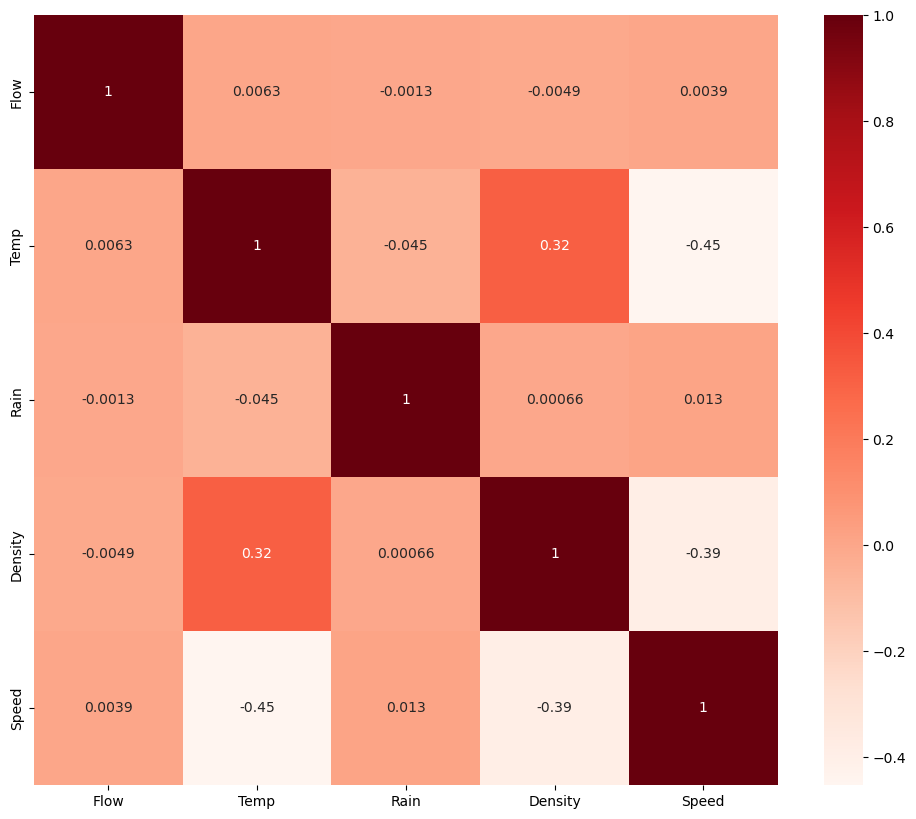

(220813, 12, 5)
(220813, 12)
n_timesteps 12
n_features 5
n_outputs 12
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 1, 1, 9, 128)      272896    
                                                                 
 dropout (Dropout)           (None, 1, 1, 9, 128)      0         
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 1, 1, 6, 128)      524800    
                                                                 
 dropout_1 (Dropout)         (None, 1, 1, 6, 128)      0         
                                                                 
 conv_lstm2d_2 (ConvLSTM2D)  (None, 1, 1, 3, 128)      524800    
                                                                 
 dropout_2 (Dropout)         (None, 1, 1, 3, 128)      0         
                                                    

C:\Users\admin\AppData\Roaming\Python\Python39\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/10
346/346 [==============================] - ETA: 0s - loss: 0.8427
Epoch 1: val_loss improved from inf to 0.28053, saving model to best_weightsconvBi.hdf5
346/346 [==============================] - 840s 2s/step - loss: 0.8427 - val_loss: 0.2805
Epoch 2/10
346/346 [==============================] - ETA: 0s - loss: 0.3228
Epoch 2: val_loss improved from 0.28053 to 0.21804, saving model to best_weightsconvBi.hdf5
346/346 [==============================] - 888s 3s/step - loss: 0.3228 - val_loss: 0.2180
Epoch 3/10
346/346 [==============================] - ETA: 0s - loss: 0.2746
Epoch 3: val_loss improved from 0.21804 to 0.20079, saving model to best_weightsconvBi.hdf5
346/346 [==============================] - 933s 3s/step - loss: 0.2746 - val_loss: 0.2008
Epoch 4/10
346/346 [==============================] - ETA: 0s - loss: 0.2554
Epoch 4: val_loss improved from 0.20079 to 0.19175, saving model to best_weightsconvBi.hdf5
346/346 [==============================] - 886s 3s/step - 

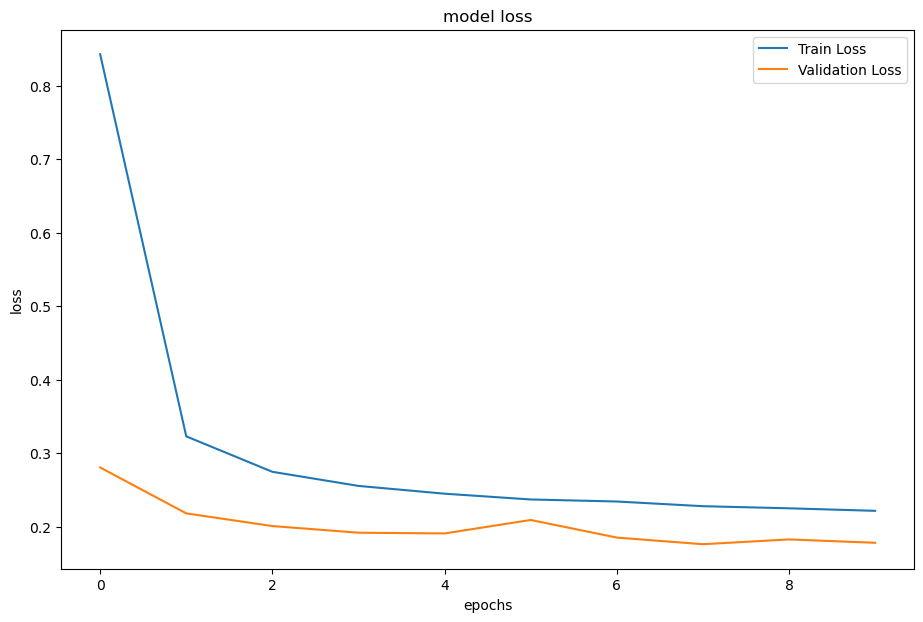

10.373330780840167
RMSE: [0.412] 0.325, 0.348, 0.354, 0.365, 0.384, 0.407, 0.422, 0.424, 0.447, 0.458, 0.482, 0.493 
MAE: [0.301] 0.241, 0.259, 0.265, 0.270, 0.280, 0.300, 0.305, 0.307, 0.327, 0.337, 0.356, 0.360 
R2: [0.864] 0.910, 0.900, 0.897, 0.893, 0.883, 0.870, 0.856, 0.857, 0.844, 0.834, 0.815, 0.813 
[0.41238484] [0.3006391] 0.8644442317366806


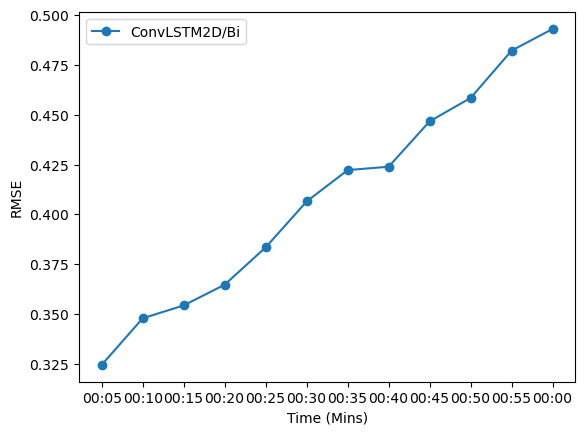

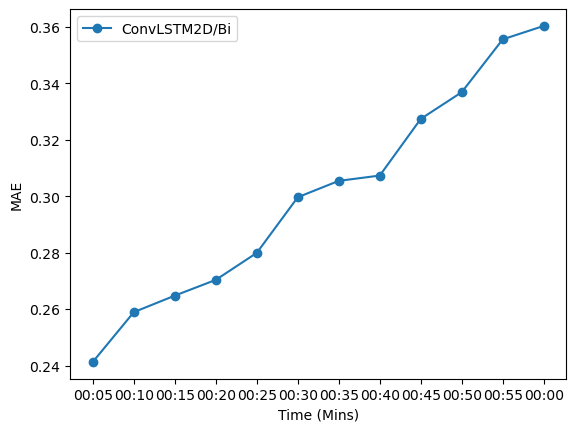

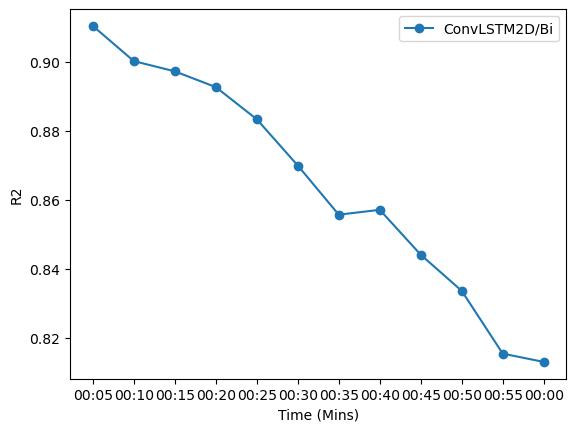

In [3]:
# import les librairies necessaires
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import ConvLSTM2D
from keras.layers import Flatten
from keras import optimizers
from pylab import rcParams
import seaborn as sns
from keras.layers import Bidirectional
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils.vis_utils import plot_model

#Configuration pour tensorflow, GPU sur pycharm
config = tf.compat.v1.ConfigProto(gpu_options=tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.8))
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)


#Diviser l'ensemble de données (dataset) en ensembles d'entraînement et de test
def split_dataset(data):
    # divisé en ensembles d'entraînement / test
    train, test = data[:-24540, :], data[-24540:, :]
    # restructurer les données en d'heures standard (12 valeur de 5 min )
    train = np.array(np.split(train, len(train) / 12))
    test = np.array(np.split(test, len(test) / 12))
    return train, test


###############################################

#Plot le resultat de courbe train / validation
def plot_result(hist):
    pyplot.figure(figsize=(11, 7))
    pyplot.plot(hist.history['loss'], label='Train Loss')
    pyplot.plot(hist.history['val_loss'], label='Validation Loss')
    pyplot.title('model loss')
    pyplot.ylabel('loss')
    pyplot.xlabel('epochs')
    pyplot.legend(loc='upper right')
    pyplot.show()
###############################################

#Plot le resultat de prediction par rapport les donnes de test (actual)
def plot_result1(actual, predicted):
    pyplot.figure(figsize=(11, 4))
    actual = actual
    pred = predicted
    pyplot.plot(actual, label='Actual')
    pyplot.plot(pred, label='Predicted')
    pyplot.legend()
    pyplot.show()
###############################################

# évaluer une ou plusieurs prédictions horaire par rapport aux valeurs prédites
def evaluate_forecasts(actual, predicted):
    scores = list()
    scores1 = list()
    scores2 = list()
    # calculer un score RMSE,MAE et R2 pour chaque échantillon
    for i in range(actual.shape[1]):
        # calcule MSE
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calcule RMSE
        rmse = np.sqrt(mse)
        # calcule MAE
        mae = mean_absolute_error(actual[:, i], predicted[:, i])
        # calcule R2
        r2 = r2_score(actual[:, i], predicted[:, i])
        # sauvgarder les scores de chaque metrique
        scores.append(rmse)
        scores1.append(mae)
        scores2.append(r2)
    # calculer le RMSE,MAE et R2 totale
    print(sum(scores2))
    s = 0
    a = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col]) ** 2
            a += abs(actual[row, col] - predicted[row, col])
    score = np.sqrt(s / (actual.shape[0] * actual.shape[1]))#RMSE totale
    score1 = (a / (actual.shape[0] * actual.shape[1]))#MAE totale
    score2 = (sum(scores2) / 12)# R2 totale
    return score, score1, score2, scores, scores1, scores2
#########################################################################

# affiche les resultats d'un modèle sur une seule ligne pour chaque metrique d'evaluation
def summarize_scores(name, names, nom, score, score1, score2, scores, scores1, scores2):
    s_scores = ', '.join(['%.3f' % s for s in scores])
    s_scores1 = ', '.join(['%.3f' % s for s in scores1])
    s_scores2 = ', '.join(['%.3f' % s for s in scores2])

    print('%s: [%.3f] %s ' % (name, score, s_scores))
    print('%s: [%.3f] %s ' % (names, score1, s_scores1))
    print('%s: [%.3f] %s ' % (nom, score2, s_scores2))
##########################################################################

# convertir les données historiques  en entrées et sorties par 'Sliding window'
def to_supervised(train, n_input, n_out=12):
    train = np.array(train)
    # aplatir les données (flatten)
    data = train.reshape((train.shape[0] * train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0
    # parcourir toute l'historique , une heure après l'autre
    for _ in range(len(data)):
        #  définir la fin de la séquence d'entrée
        in_end = in_start + n_input
        out_end = in_end + n_out #la fin de la séquence de sortie
        # determiner les données d'entrée et de sortie en cas (out_end <= len(data))
        if out_end <= len(data):
            # x_input = data[in_start:in_end, 0]
            # x_input = x_input.reshape((len(x_input), 1))
            X.append(data[in_start:in_end, :]) #prend la sequence avec tout les features comme en entrée
            # X.append(x_input)
            y.append(data[in_end:out_end, 0]) #la sortie specifie a le flux de trafic

        # se déplacer d'un pas de temps pour parcourir tout l'historique
        in_start += 1
    return np.array(X), np.array(y)
#########################################################

# Construire et train le modèle
def build_model(train, n_steps, n_length, n_input):
    # prépare les données d'apprentissage
    train_x, train_y = to_supervised(train, n_input)
    print(train_x.shape)
    print(train_y.shape)
    # définit le modèle (hyperparamètre)
    verbose, epochs, batch_size = 1, 10, 512
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    print("n_timesteps", n_timesteps)
    print("n_features", n_features)
    print("n_outputs", n_outputs)
    # remodeler l'entrée au [samples, time steps, rows, cols, channels] (5 dim)
    train_x = train_x.reshape((train_x.shape[0], n_steps, 1, n_length, n_features))
    # remodeler la sortie [samples, timesteps, features] au lieu 2 dimension
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
    # le modèle
    model = Sequential()
    model.add(ConvLSTM2D(filters=128, kernel_size=(1, 4), activation='relu', return_sequences=True,
                         input_shape=(n_steps, 1, n_length, n_features)))
    model.add(Dropout(0.2))
    model.add(ConvLSTM2D(filters=128, kernel_size=(1, 4), activation='relu', return_sequences=True))
    model.add(Dropout(0.2))
    model.add(ConvLSTM2D(filters=128, kernel_size=(1, 4), activation='relu', return_sequences=True))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(RepeatVector(n_outputs))
    model.add(Bidirectional(LSTM(512, activation='relu', return_sequences=True),
                            input_shape=(n_steps, 1, n_length, n_features)))
    model.add(Dropout(0.2))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer=optimizers.Adam(lr=0.0001))
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
    checkpointer = ModelCheckpoint(filepath="best_weightsconvBi.hdf5",
                                   monitor='val_loss',
                                   verbose=2,
                                   save_best_only=True)
    callbacks_list = [checkpointer, es]  # early
    model.summary()
    plot_model(model, to_file='model_plotconv.png', show_shapes=True, show_layer_names=True)
    # entrainement le modèle
    history = model.fit(train_x, train_y, epochs=epochs, callbacks=callbacks_list, batch_size=batch_size,
                        verbose=verbose,
                        validation_split=0.2)
    plot_result(history) #dessin le graphe de perte

    model.load_weights('best_weightsconvBi.hdf5')
    model.save('modelconvBi.h5')

#retourne un modéle prêt à faire des prédictions.
    return model
####################################################

# faire la prediction
def forecast(model, history, n_steps, n_length, n_input):
    #flatten data pour d'obtenir 12 séries temporelles parallèles.
    data = np.array(history)
    data = data.reshape((data.shape[0] * data.shape[1], data.shape[2]))
    #récupérer les dernières observations pour les données d'entrée
    input_x = data[-n_input:, :] #les dernières 12 valeur de flux de trafic
    # reshape l'entrée à (5) dim [1, n_input, 1]
    input_x = input_x.reshape((1, 1, 1, input_x.shape[0], input_x.shape[1]))
    #faire la prédiction
    yhat = model.predict(input_x, verbose=0)
    # pour faire la prédiction en vectorielle
    yhat = yhat[0]
    # print("yhat",yhat)
    return yhat
#####################################################

# évaluer le modèle
def evaluate_model(train, test, n_steps, n_length, n_input):
    # entrainement du modèle
    model = build_model(train, n_steps, n_length, n_input)
    # historique est liste de données d'heureur
    history = [x for x in train]
    # walk-forward validation sur chaque heure
    predictions = list()
    for i in range(len(test)):
        # prédire l'heure
        yhat_sequence = forecast(model, history, n_steps, n_length, n_input)
        # stocker les prédictions
        predictions.append(yhat_sequence)
        # obtenir une observation réelle et l'ajouter à l'historique pour prédire la semaine suivante.
        history.append(test[i, :])
    # évaluer les prédictions mins pour une heure
    predictions = np.array(predictions)
    score, score1, score2, scores, scores1, scores2 = evaluate_forecasts(test[:, :, 0], predictions)

    return score, score1, score2, scores, scores1, scores2
############################################################

# charger toutes les données (dataset)
dataset = pd.read_csv('Trafficdataset.csv', header=0, infer_datetime_format=True,
                      parse_dates=['datDateTime'], index_col=['datDateTime'])
print("la taille de data ")
# plot Le matrice de correlation ###
pyplot.figure(figsize=(12,10))
cor = dataset.corr()
sns.heatmap(cor, annot=True, cmap=pyplot.cm.Reds)
pyplot.show()
######################################

dataset = dataset.iloc[:-1, :] #pour specifier les lignes et les colonnes de dataset
train, test = split_dataset(dataset.values) #appele la fonction split_dataset pour la division de le dataset
train, trainy = train[:, :, :-1], train[:, :, -1]
test, testy = test[:, :, :-1], test[:, :, -1]

# standardiser (train/test)
mu = np.mean(train) #la Moyenne de donnes de train
sig = np.std(train) #l'ecart type de train

dataTrainStandardized = (train - mu) / sig #datatrain standardiser

test_res = (test - mu) / sig #datatest standardiser

train = pd.DataFrame(dataTrainStandardized.reshape((dataTrainStandardized.shape[0] * dataTrainStandardized.shape[1]),
                                                   dataTrainStandardized.shape[2]))
train['y'] = pd.DataFrame(trainy.reshape(trainy.shape[0] * trainy.shape[1], 1))

test = pd.DataFrame(test_res.reshape((test_res.shape[0] * test_res.shape[1]), test_res.shape[2]))
test['y'] = pd.DataFrame(testy.reshape(testy.shape[0] * testy.shape[1], 1))
# convert to DF
train = np.array(train)
train = train.reshape(train.shape[0] // 12, 12, train.shape[1])
test = np.array(test)
test = test.reshape(test.shape[0] // 12, 12, test.shape[1])

#supprimer le nom des varaible
del trainy, testy, dataTrainStandardized, test_res

# evaluation de modéle et retourne le score, scores
n_steps, n_length = 1, 12
n_input = n_length * n_steps
rmseconvl5, maeconvl5, r2convl5, convlrmse5, convlmae5, convlr25 = evaluate_model(train, test, n_steps, n_length,
                                                                                  n_input)
# summarize scores
summarize_scores('RMSE', 'MAE', 'R2', rmseconvl5, maeconvl5, r2convl5, convlrmse5, convlmae5, convlr25)
print(rmseconvl5, maeconvl5, r2convl5)
############ Plot les resultats (scores) de la prediction #################
mins = ['00:05', '00:10', '00:15', '00:20', '00:25', '00:30', '00:35', '00:40', '00:45', '00:50', '00:55', '00:00']

pyplot.plot(mins, convlrmse5, marker='o', label='ConvLSTM2D/Bi')
pyplot.xlabel("Time (Mins)")
pyplot.ylabel("RMSE")
pyplot.legend()
pyplot.show()

pyplot.plot(mins, convlmae5, marker='o', label='ConvLSTM2D/Bi')
pyplot.xlabel("Time (Mins)")
pyplot.ylabel("MAE")
pyplot.legend()
pyplot.show()

pyplot.plot(mins, convlr25, marker='o', label='ConvLSTM2D/Bi')
pyplot.xlabel("Time (Mins)")
pyplot.ylabel("R2")
pyplot.legend()
pyplot.show()
##################################################################################
